In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import numpy as np
import math
import joblib
import itertools
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch

from models import Encoder, Decoder, Dynamics, Policy, Discriminator
from utils import Tensor, reparameterization, grouper, z_separation_accuracy, save_model, load_model, save_metrics, load_metrics
from gen_data import Data
from train import train

In [3]:
cuda = True if torch.cuda.is_available() else False

In [ ]:
%%bash
python gen_data.py

In [5]:
train_data_s, train_data_t, test_data_s, test_data_t = joblib.load(os.path.join('./data/mnist_prep', 'all_data.pkl'))

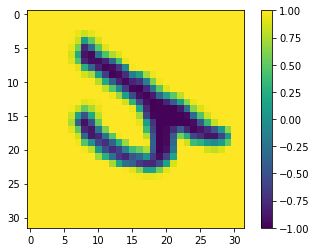

In [6]:
plt.imshow(test_data_t.obs_[4,0].cpu().numpy())
plt.colorbar()

In [ ]:
%%bash
python train.py --domain=source

In [ ]:
%%bash
python train.py --domain=target --seed=2

In [9]:
metrics_dict_s = load_metrics('./logs', 'source')
metrics_dict_t = load_metrics('./logs', 'target')

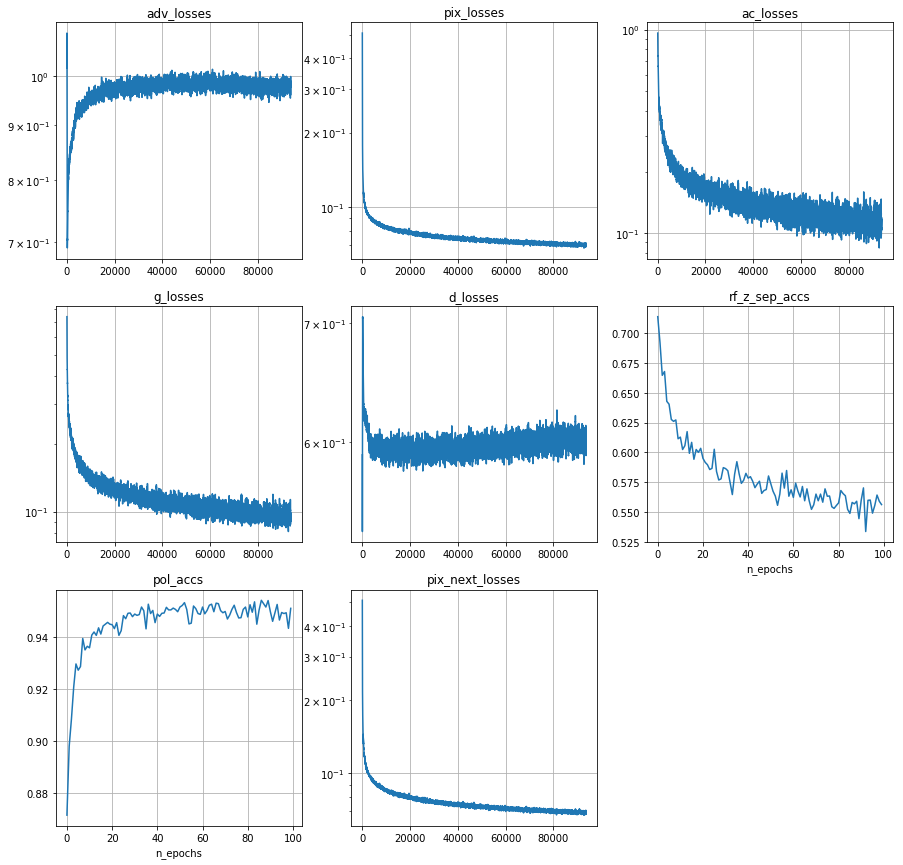

In [10]:
plt.figure(figsize=(15, 20))
window_size = 50

for i, (k, v) in enumerate(metrics_dict_s.items()):
    plt.subplot(4, 3, i+1)
    plt.grid()
    plt.title(k)
    if not k.endswith('accs'):
        plt.plot(np.convolve(v, np.ones(window_size) / window_size, mode='valid'))
        plt.yscale('log')
    else:
        plt.xlabel('n_epochs')
        plt.plot(v)

plt.show()

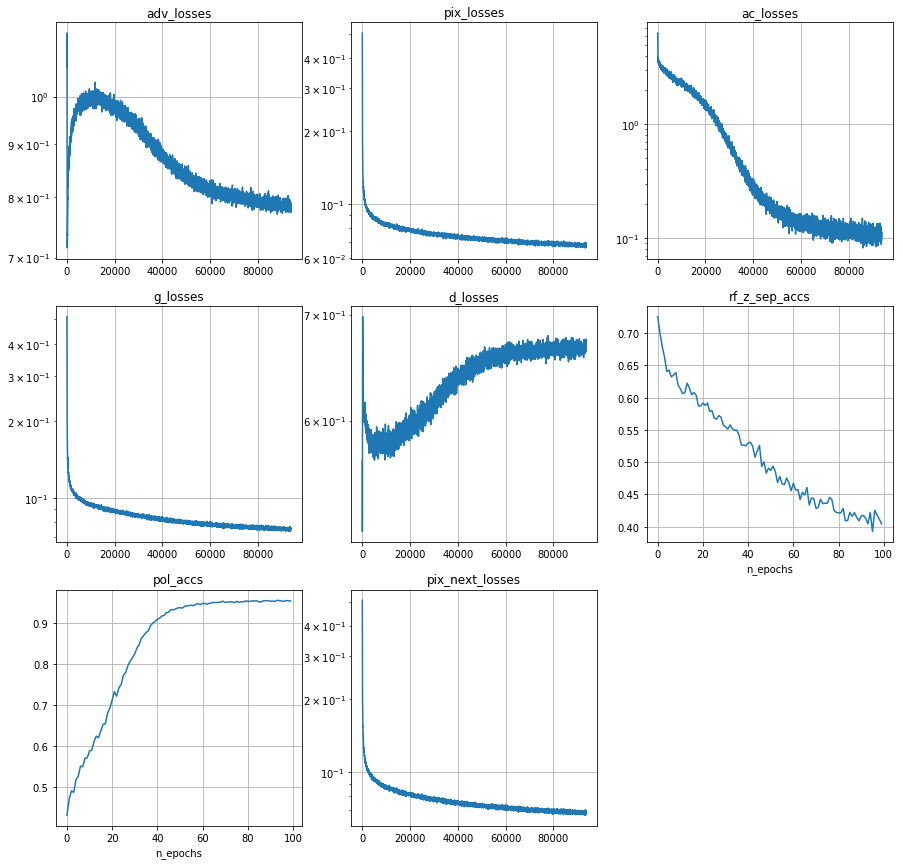

In [11]:
plt.figure(figsize=(15, 20))
window_size = 50

for i, (k, v) in enumerate(metrics_dict_t.items()):
    plt.subplot(4, 3, i+1)
    plt.grid()
    plt.title(k)
    if not k.endswith('accs'):
        plt.plot(np.convolve(v, np.ones(window_size) / window_size, mode='valid'))
        plt.yscale('log')
    else:
        plt.xlabel('n_epochs')
        plt.plot(v)

plt.show()

In [12]:
model_s = load_model('./models', 'source')
model_t = load_model('./models', 'target')

In [13]:
n = 10
obs_s = train_data_s.obs[:n].cuda() if cuda else train_data_s.obs[:n]
acs_s = train_data_s.acs[:n].cuda() if cuda else train_data_s.acs[:n]
obs_t = train_data_t.obs[:n].cuda() if cuda else train_data_t.obs[:n]
acs_t = train_data_t.acs[:n].cuda() if cuda else train_data_t.acs[:n]

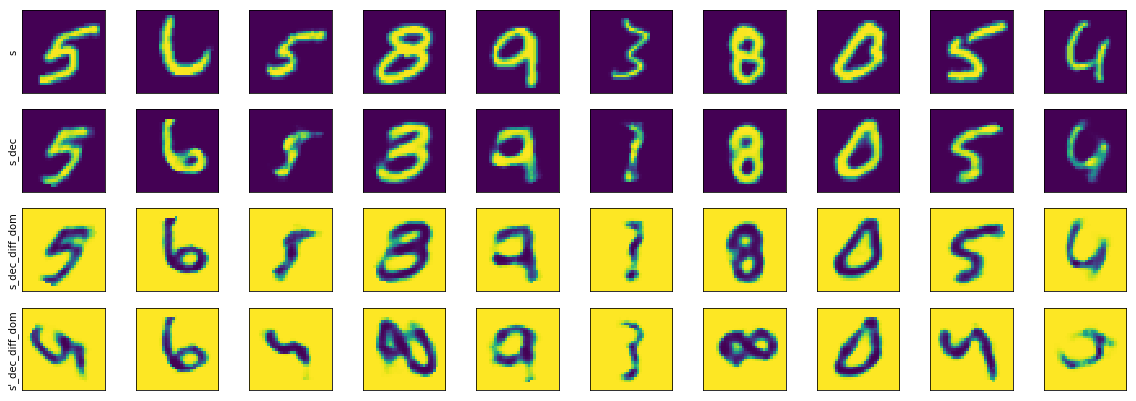

In [14]:
plt.figure(figsize=(n * 2, 7))
nrows = 4

for l in range(n):
    plt.subplot(nrows, n, 0*n+l+1)
    plt.imshow(obs_s[l, 0].cpu().data.numpy())
    if l == 0:
        plt.ylabel('s')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(nrows, n, 1*n+l+1)
    decoded_obs_ss = model_s['dec'](model_s['enc'](obs_s))
    plt.imshow(decoded_obs_ss[l, 0].cpu().data.numpy())
    if l == 0:
        plt.ylabel('s_dec')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(nrows, n, 2*n+l+1)
    decoded_obs_st = model_t['dec'](model_s['enc'](obs_s))
    plt.imshow(decoded_obs_st[l, 0].cpu().data.numpy())
    if l == 0:
        plt.ylabel('s_dec_diff_dom')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(nrows, n, 3*n+l+1)
    #decoded_next_obs_t = model_t['dec_next'](model_s['enc'](obs_s))
    decoded_next_obs_st = model_t['dec_next'](model_s['dyn'](model_s['enc'](obs_s), acs_s))
    plt.imshow(decoded_next_obs_st[l, 0].cpu().data.numpy())
    if l == 0:
        plt.ylabel('s\'_dec_diff_dom')
    plt.xticks([])
    plt.yticks([])
    
plt.show()

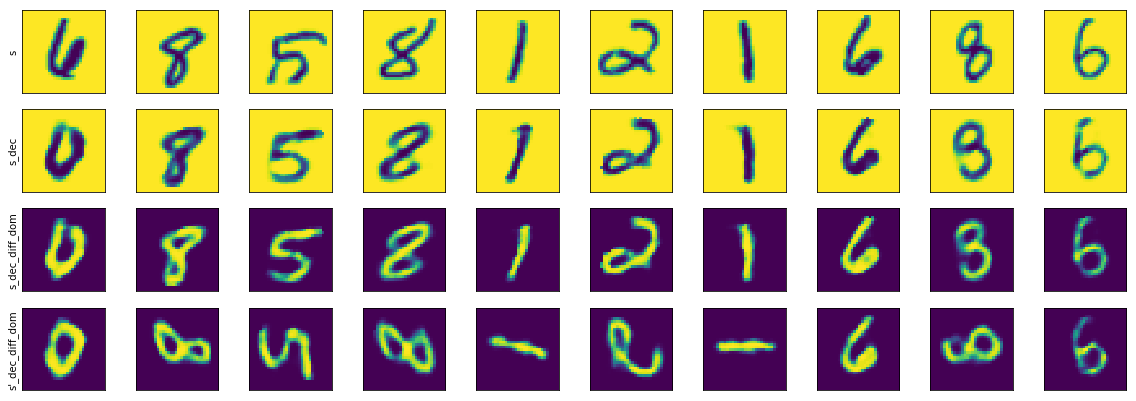

In [15]:
plt.figure(figsize=(n * 2, 7))
nrows = 4

for l in range(n):
    plt.subplot(nrows, n, 0*n+l+1)
    plt.imshow(obs_t[l, 0].cpu().data.numpy())
    if l == 0:
        plt.ylabel('s')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(nrows, n, 1*n+l+1)
    decoded_obs_tt = model_t['dec'](model_t['enc'](obs_t))
    plt.imshow(decoded_obs_tt[l, 0].cpu().data.numpy())
    if l == 0:
        plt.ylabel('s_dec')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(nrows, n, 2*n+l+1)
    decoded_obs_ts = model_s['dec'](model_t['enc'](obs_t))
    plt.imshow(decoded_obs_ts[l, 0].cpu().data.numpy())
    if l == 0:
        plt.ylabel('s_dec_diff_dom')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(nrows, n, 3*n+l+1)
    decoded_next_obs_ts = model_s['dec_next'](model_s['dyn'](model_t['enc'](obs_t), acs_t))
    plt.imshow(decoded_next_obs_ts[l, 0].cpu().data.numpy())
    if l == 0:
        plt.ylabel('s\'_dec_diff_dom')
    plt.xticks([])
    plt.yticks([])

plt.show()